In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import equity_plot
import lightgbm as lgb
from sklearn import metrics
import datetime
from equity_plot import equity_plot
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings('ignore')

In [25]:
var_list = np.load('var.npy').tolist()

In [5]:
replace_dic = {}
for i in range(1,20) :
    replace_dic[' '*i+'-'] = np.nan
replace_dic[''] = np.nan

In [6]:
loan = pd.read_csv('stock/predict/loan.txt',sep = '\t', encoding="mbcs").drop(0).replace(replace_dic).drop(['簡稱'],axis = 1).rename(columns = {'年月日':'date','公司代碼':'code'})
intra = pd.read_csv('stock/predict/intra.txt',sep = '\t', encoding="mbcs").drop(0).drop(['簡稱'],axis = 1).replace(replace_dic).rename(columns = {'日期':'date','代碼':'code'})
price = pd.read_csv('stock/predict/price.txt',sep = '\t', encoding="mbcs").drop(0).drop(['簡稱'],axis = 1).replace(replace_dic).rename(columns = {'年月日':'date','證券代碼':'code'})

In [7]:
# 融資券
loan['date'] = pd.to_datetime(loan.date)
loan['是否可信用交易(Y)'] = np.where(loan['是否可信用交易(Y)'] == 'Y',1,0)
loan.iloc[:,2:] = loan.iloc[:,2:].astype(float)

# 當沖資料
intra['date'] = pd.to_datetime(intra.date)
intra.iloc[:,2:] = intra.iloc[:,2:].astype(float)
# intra = intra.drop(['報酬率％','週轉率％'],axis = 1)

# 價格
price['date'] = pd.to_datetime(price.date)
price['注意股票(A)'] = np.where(price['注意股票(A)'] == 'A',1,0)
price['處置股票(D)'] = np.where(price['處置股票(D)'] == 'D',1,0)
price['漲跌停'] = np.where(price['漲跌停'] == '+',1,
                       np.where(price['漲跌停'] == '-',-1,0))
price = price.drop(['全額交割(Y)','市場別'],axis = 1)
price.iloc[:,2:] = price.iloc[:,2:].astype(float)

#### calculate feature

In [8]:
merge_data_raw = price.merge(intra,on = ['code','date'], how = 'left').merge(loan,on = ['code','date'], how = 'left')

In [9]:
## 股價區
merge_data = merge_data_raw.copy()

merge_data['intraday_ret'] = merge_data['收盤價(元)']/merge_data['開盤價(元)'] -1
merge_data['high_ret'] = merge_data['最高價(元)']/merge_data['開盤價(元)'] -1
merge_data['low_ret'] = merge_data['最低價(元)']/merge_data['開盤價(元)'] -1
merge_data['close_1'] = merge_data.groupby('code')['收盤價(元)'].shift(1)
merge_data['jump'] = merge_data['開盤價(元)']/merge_data['close_1'] -1

## 均線
merge_data = merge_data.sort_values(['code','date'])
merge_data['5ma_vol'] = merge_data.groupby(merge_data['code'])['收盤價(元)'].rolling(5).std().values
merge_data['5volume_vol'] = merge_data.groupby(merge_data['code'])['成交量(千股)'].rolling(5).std().values
merge_data['5ma_ret'] = merge_data.groupby(merge_data['code'])['報酬率％'].rolling(5).std().values

In [10]:
merge_data['intraday_ret_led1'] = merge_data.groupby('code')['intraday_ret'].shift(-1)

In [11]:
merge_data['trend'] = np.where(merge_data['intraday_ret_led1']>=0 , 1 ,-1)

<AxesSubplot:>

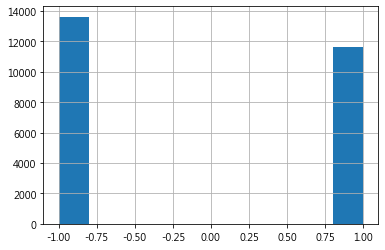

In [12]:
merge_data['trend'].hist()

#### Loaded Model

In [13]:
model = lgb.Booster(model_file='mode.txt')

In [14]:
testx = merge_data.loc[:,var_list]
testy = merge_data.loc[:,'trend']

In [15]:
test_pred=model.predict(testx)

#### BT

In [16]:
merge_data['pred'] = test_pred

In [17]:
#Train
test_bt_pivot = merge_data.reset_index().pivot_table(index = 'date',values = 'pred',columns = 'code')
test_intraday_pivot = merge_data.reset_index().pivot_table(index = 'date',values = 'intraday_ret_led1',columns = 'code')
test_volume_pivot = merge_data.reset_index().pivot_table(index = 'date',values = '成交量(千股)',columns = 'code')
test_vol_pivot = merge_data.reset_index().pivot_table(index = 'date',values = '收盤價(元)',columns = 'code').rolling(5).std()
test_bt_time = test_bt_pivot.index

In [18]:
merge_data['prob_cut'] = pd.cut(merge_data['pred'],bins = 10,labels = [x for x in range(0,10)])
merge_data['prob_cut'] = pd.cut(merge_data['pred'],bins = 10)

<AxesSubplot:title={'center':'intraday_ret_led1'}, xlabel='[prob_cut]'>

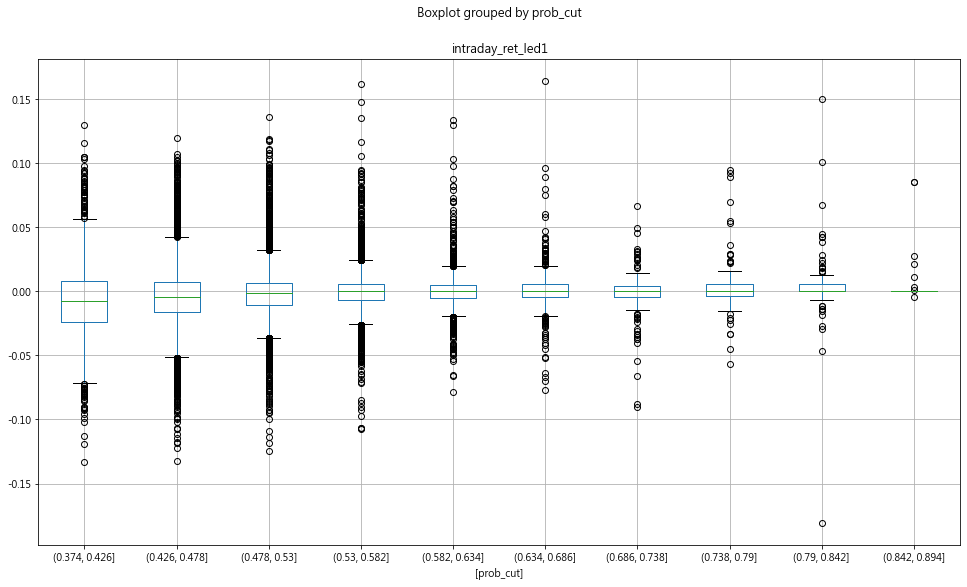

In [19]:
merge_data[['intraday_ret_led1','prob_cut']].boxplot(by ='prob_cut' ,figsize = (16,9))

In [20]:
test_long_ret = {}
test_long_target = {}
p = 0.53
fee = -0.001425*2-0.003
# fee = 0
for day in range(len(test_bt_time)-1) :
    
    test_long_stock_list = signal(test_bt_pivot,day,p,
                                   test_bt_time,test_volume_pivot,test_vol_pivot)
    
    test_long_ret[test_bt_time[day]] = ((test_intraday_pivot.loc[test_bt_time[day],test_long_stock_list].mean())*1)-fee
    test_long_target[test_bt_time[day]] = test_long_target
    

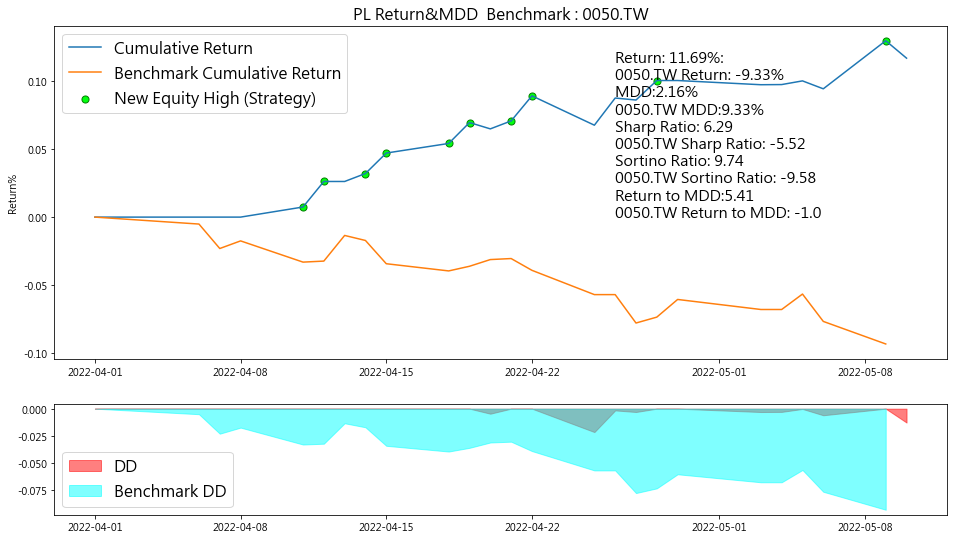

In [21]:
for i in [test_long_ret] :
    equity_plot(pd.DataFrame([i]).T.fillna(0).cumsum(),'0050.TW','PL',1)

#### Report

In [22]:
for day in range(len(test_bt_time)) :
    test_long_stock_list = signal(test_bt_pivot,day,p,
                                   test_bt_time,test_volume_pivot,test_vol_pivot)
    if day < len(test_bt_time)-1 :
        if test_intraday_pivot.loc[test_bt_time[day],test_long_stock_list].sum() != 0 :
            print(test_intraday_pivot.loc[test_bt_time[day],test_long_stock_list])
    else :
        print(test_long_stock_list)

code
6202       0.000000
8996      -0.003390
2108       0.043088
3092      -0.020281
3035       0.005357
2308       0.004040
4919      -0.009346
2345       0.004673
3189       0.010899
2340       0.000000
2314      -0.005000
2498       0.009346
3532      -0.007921
3006      -0.018450
3037       0.018957
3017      -0.014019
8046       0.008889
Name: 2022-04-11 00:00:00, dtype: float64
code
2308       0.009881
2330       0.015957
Name: 2022-04-12 00:00:00, dtype: float64
code
2481      -0.006061
2338      -0.026190
3035       0.048077
4919       0.033113
2330       0.003578
4755       0.000000
3532      -0.015351
8046       0.036471
Name: 2022-04-15 00:00:00, dtype: float64
code
4133       0.004184
2330      -0.001767
Name: 2022-04-18 00:00:00, dtype: float64
code
6598       0.028571
3006       0.000000
2330       0.000000
Name: 2022-04-19 00:00:00, dtype: float64
code
2330      -0.010508
Name: 2022-04-20 00:00:00, dtype: float64
code
3661       0.016089
2308      -0.008386
2330      -0.

In [23]:
today = signal(test_bt_pivot,len(test_bt_time)-1,p,test_bt_time,test_volume_pivot,test_vol_pivot)
today_list = [x[0:4]+'.TW' for x in list(today)]

In [24]:
stock_intra_ret(today_list,str(test_bt_time[-1]))

----- 2022-05-11 00:00:00 -----
2882.TW 	 [-0.02169983]
3059.TW 	 [0.05494499]
1301.TW 	 [-0.01470588]
2031.TW 	 [-0.01960784]
3645.TW 	 [-0.03749998]
6235.TW 	 [-0.02560459]
1612.TW 	 [-0.01939658]
2330.TW 	 [-0.02131783]
1605.TW 	 [0.00267376]
3704.TW 	 [-0.02499999]
4133.TW 	 [-0.0509684]


交易股數 :	11
Average return (未扣手續費) :	-0.016198
Average return (扣手續費) :	-0.022048


#### Function

In [1]:
def signal(df,date,prob,time_df,volume_df,vol_df) :
        
    prob = df.loc[time_df[date]][df.loc[time_df[date]] >= prob].index
    volume = volume_df.loc[time_df[date]][volume_df.loc[time_df[date]] >= 4000].index
    vol = vol_df.loc[time_df[date]][vol_df.loc[time_df[date]] >= 1.5].index
    
#     volume = volume_df.loc[time_df[date]][volume_df.loc[time_df[date]] >= 0].index
#     vol = vol_df.loc[time_df[date]][vol_df.loc[time_df[date]] >= 0].index
    
    return set(prob)&set(volume)&set(vol)

In [2]:
def stock_intra_ret(stocks,day) :
    import matplotlib.pyplot as plt
    from matplotlib import gridspec
    import yfinance as yf
    import pandas as pd
    import datetime as dt
    import time
    
    ret_list = []
    
    print('-----',day,'-----')
    
    for stock in stocks :

        df = pd.DataFrame( yf.Ticker(stock).history(day))
        returns = df['Close']/df['Open']-1
        print(stock,'\t',returns.values)
        ret_list.append(returns)
    print('\n')
    print('交易股數 :\t%s' %(len(ret_list)))
    print('Average return (未扣手續費) :\t%f' %(np.mean(ret_list)))
    print('Average return (扣手續費) :\t%f' %(np.mean(ret_list)-0.001425*2-0.003))